
**En este notebook vamos a aplicar la mascara entrenada en el notebook 07**

En el notebook anterior hemos entrenado la arquitectura Unet que es capaz de predicir la mascara de un coche.

Esto lo hemos echo con el objetivo de mejorar el rendimiento de la red PixToPix (o DiscoGan) añadiendo mas coches al dataset original.

Standford car Dataset es mas rico en en cantidad de coches, el problema, es que en standford cars dataset no tenemos la mascara y aplicar el algoritmo de cany edge detection para simular los trazos humanos, seguro que no sera tan efectivo si lo aplicamos sobre el coche unicamente sin fondo.(aunque deberiamos de probarlo...)

El obejtivo de este notebook es aplicar la mascara entrenada con el carvana cars dataset sobre el standford y ver que tal es.


**Conclusiones finales del notebook**
REGULAR!, En el notebook anterior hemos visto que la mascara es muy buena y funciona muy bien, incluso en el test set.
Aplicando esta maskara con el Standford dataset, si es cierto que para algunos coches el resultado es muy decente para otros no tanto.
Mi opinion es que antes de seguir adelante debemos mejorar el modelo de mask segmentation del notebook anterior. Tengo un as en la manga, y es que en el dataset anterior NO hemos aplicado augmentación...(y podemos probar otra arquitectura a ver que pasa..) así que vamos a probarlo en el siguiente Notebook




In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import os
from skimage.transform import resize
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.io import imread, imshow #, concatenate_images
import PIL 
from PIL import Image
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

['07-tfm-cardrawing-firstaprox-unet-segment-mask', 'manualdraw', 'carvana-image-masking-challenge', 'stanford-car-dataset-by-classes-folder']


Using TensorFlow backend.


In [2]:
!ls '../input/07-tfm-cardrawing-firstaprox-unet-segment-mask/'

model_file = '../input/07-tfm-cardrawing-firstaprox-unet-segment-mask/unet-carvana.hdf5'

__notebook__.ipynb  __results__.html   custom.css
__output__.json     __results___files  unet-carvana.hdf5


In [3]:
model = load_model(model_file)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
________________________________________________________________________

In [8]:
standfordcars = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train'

In [14]:
images=[]
for x in os.listdir(standfordcars):
    for image in os.listdir(standfordcars+'/'+str(x)):
        images.append(standfordcars+'/'+str(x)+'/'+image)
        
print(len(images))
images[0:5]

8144


['../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Ferrari California Convertible 2012/06401.jpg',
 '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Ferrari California Convertible 2012/03549.jpg',
 '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Ferrari California Convertible 2012/02122.jpg',
 '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Ferrari California Convertible 2012/08093.jpg',
 '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Ferrari California Convertible 2012/07829.jpg']

In [16]:
# Vamos a hacer print de unas 30 imagenes random
randomimg = np.random.choice(images,30)
randomimg

array(['../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Nissan Juke Hatchback 2012/01141.jpg',
       '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/BMW X6 SUV 2012/04149.jpg',
       '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Hyundai Genesis Sedan 2012/03290.jpg',
       '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Geo Metro Convertible 1993/06242.jpg',
       '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Chevrolet Camaro Convertible 2012/01342.jpg',
       '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/AM General Hummer SUV 2000/01952.jpg',
       '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Chevrolet Impala Sedan 2007/04267.jpg',
       '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/HUMMER H3T Crew Cab 2010/06404.jpg',
       '../input/stanford-car-dataset-by-classes-fold

In [18]:
H = 256
W = 256
BATCH_SIZE=32
def downsample(img, h, w):    
    ret = resize(img, (h, w), mode='constant', preserve_range=True)
    # plt.imshow(ret)
    return ret
    #return cv2.resize(img, (h, w))

In [21]:
#Leemos las images y les hacemos el resize al final tenemos un numpy con 30 images,256,256,3
input_arr = []
for img in randomimg:
    input_arr.append(downsample(imread(img)/255,H,W))
    
input_arr = np.array(input_arr)
print(input_arr.shape)
print(input_arr)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(30, 256, 256, 3)
[[[[0.93844975 0.93060662 0.93452819]
   [1.         1.         1.        ]
   [0.98884804 0.98884804 0.98884804]
   ...
   [0.85594363 0.78713235 0.80603554]
   [0.65447304 0.35548407 0.43903186]
   [0.59010417 0.81124387 0.72536765]]

  [[0.92585784 0.91801471 0.92193627]
   [0.99947917 0.99947917 0.99947917]
   [0.98026961 0.98026961 0.98026961]
   ...
   [0.8421875  0.64001225 0.73066789]
   [0.82662377 0.84583333 0.82193627]
   [0.63146446 0.31338848 0.42037377]]

  [[0.92941176 0.92156863 0.9254902 ]
   [0.99617034 0.99617034 0.99617034]
   [0.97264093 0.97264093 0.97264093]
   ...
   [0.96253064 0.99004289 0.99509804]
   [0.99411765 0.94993873 0.96920956]
   [0.7299326  0.8580576  0.80465686]]

  ...

  [[0.68250613 0.65006127 0.59908088]
   [0.67147672 0.64479167 0.58204657]
   [0.66020221 0.60922181 0.54353554]
   ...
   [0.57147672 0.53226103 0.49304534]
   [0.57858456 0.52662377 0.49132966]
   [0.5731924  0.52809436 0.5104473 ]]

  [[0.66645221 0.61259191 0

In [23]:
#Predecimos la mascara
preds = model.predict(input_arr)
print(preds.shape)

(30, 256, 256, 1)


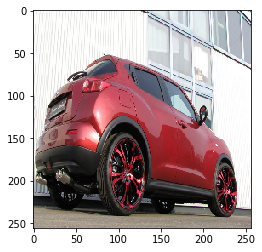

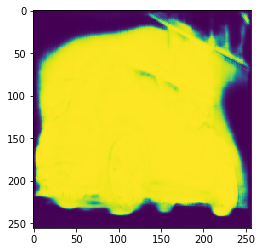

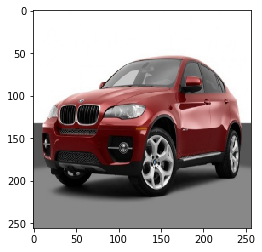

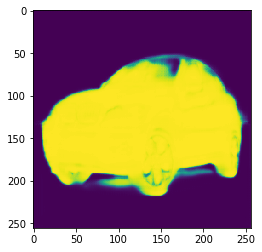

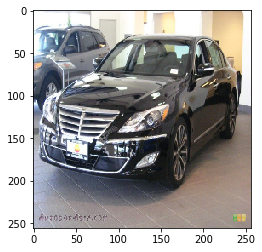

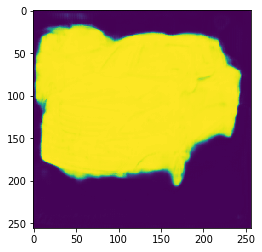

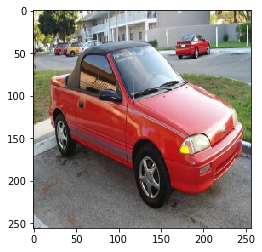

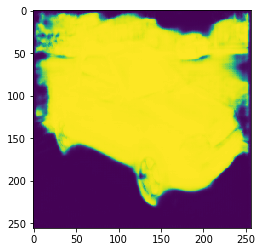

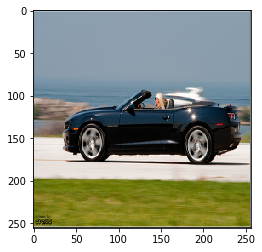

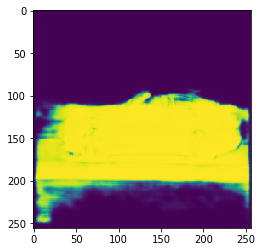

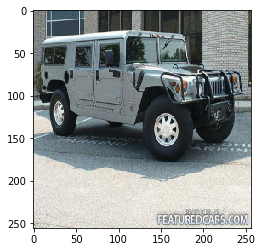

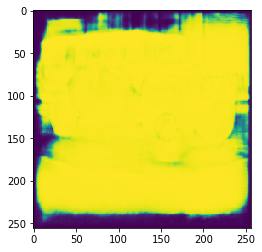

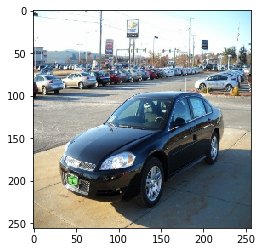

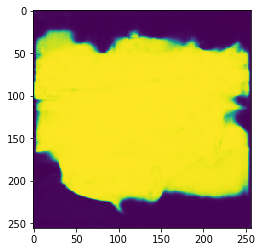

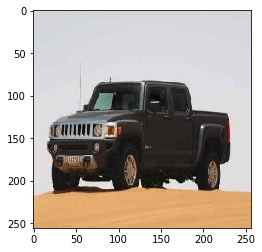

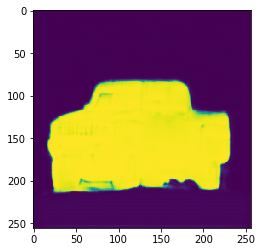

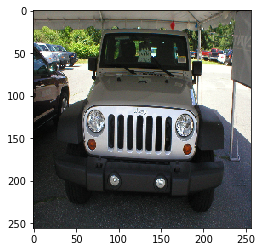

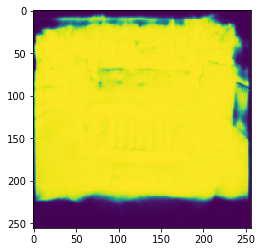

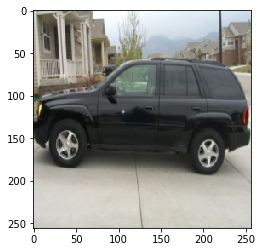

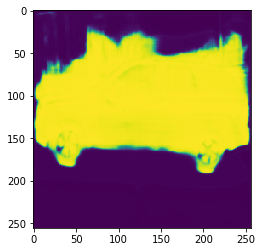

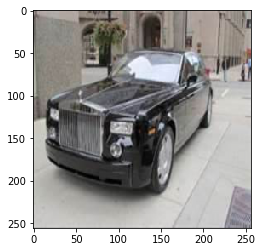

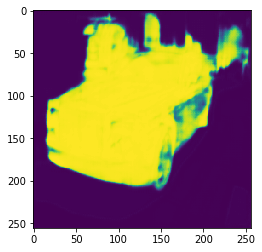

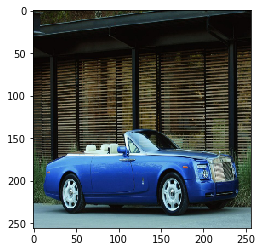

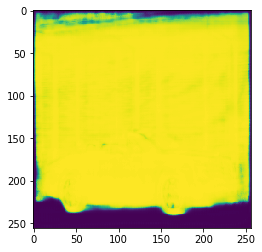

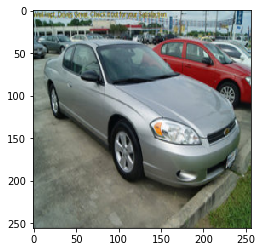

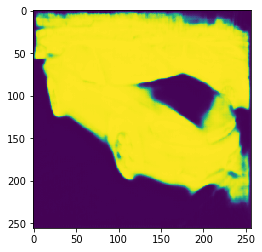

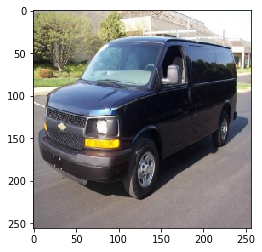

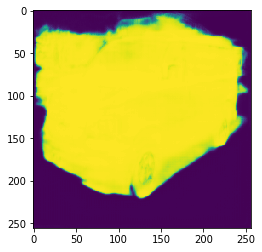

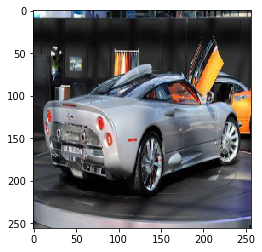

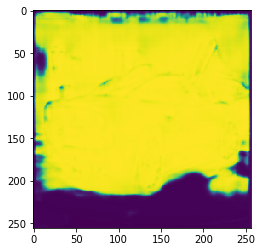

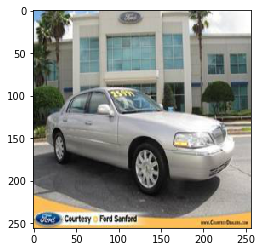

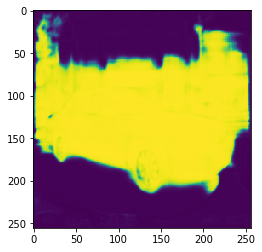

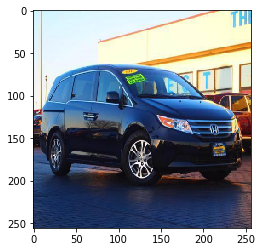

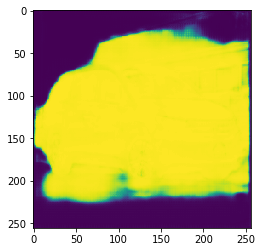

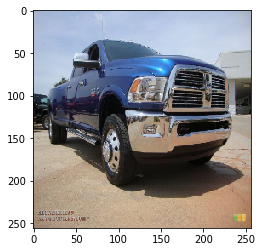

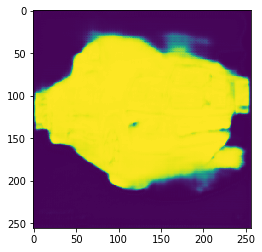

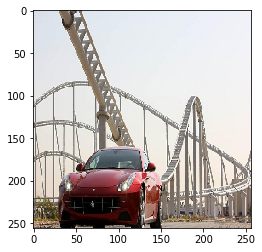

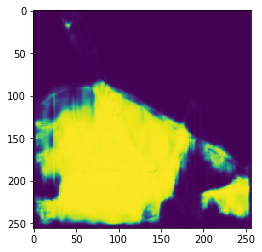

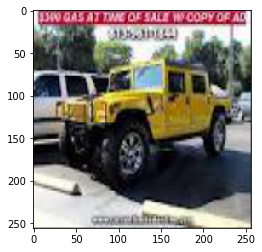

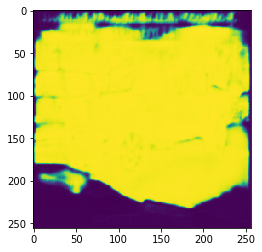

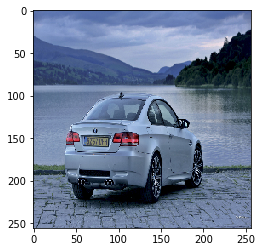

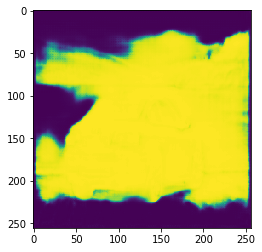

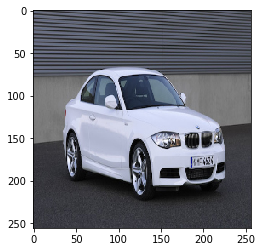

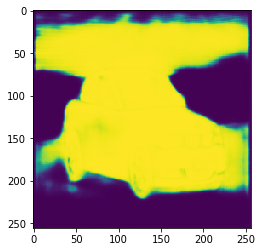

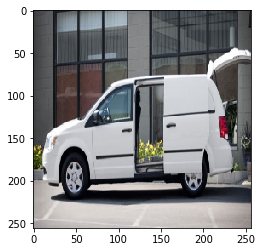

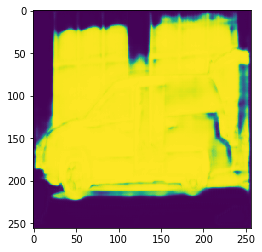

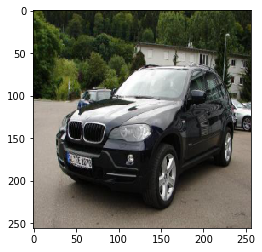

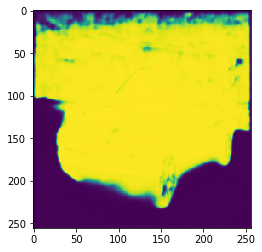

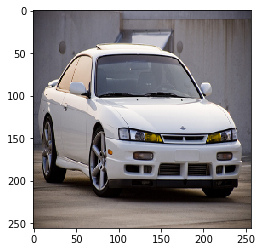

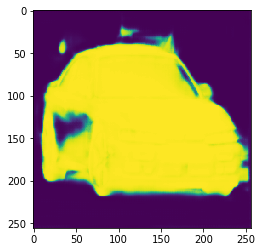

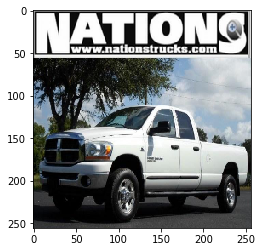

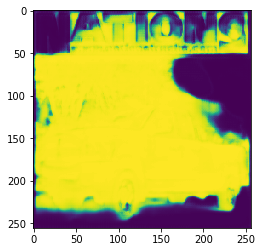

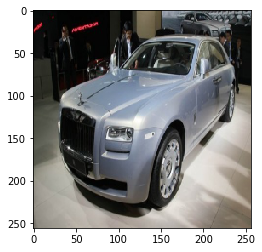

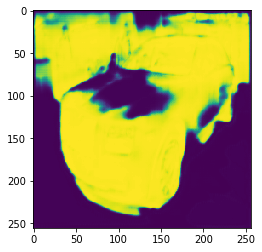

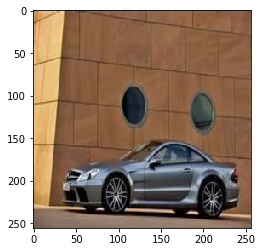

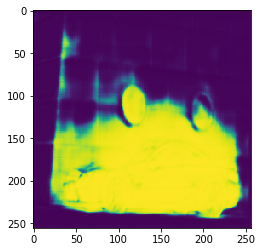

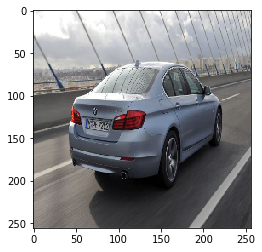

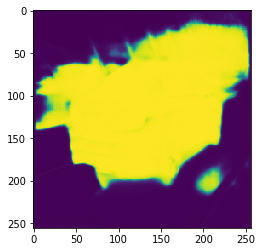

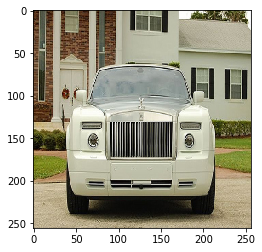

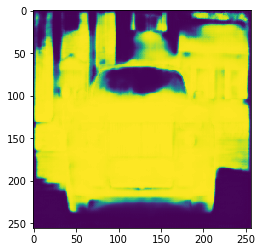

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

for img, pred in zip(input_arr, preds):
    plt.imshow((img))
    plt.show()
    plt.imshow((pred.reshape(H,W)))
    plt.show()

In [29]:
# LEER conclusiones al principio